In [11]:
imsize = 75
imchanel = 1
labels = ['Extra_oral','Intra_oral','Radiography']

train_dir = 'images_overall' 
test_dir = 'images_overall'
valid_dir = 'images_overall'

In [2]:

import os
import random
from IPython.display import display
import warnings
import cv2
import time
import shutil
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
sns.set_style('darkgrid')
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from sklearn.model_selection import train_test_split
from keras.metrics import categorical_crossentropy
from keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
def define_paths(dir):
    filepaths = []
    labels = []
    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
    return filepaths, labels

def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

def create_df(tr_dir, val_dir, ts_dir):
    # train dataframe
    files, classes = define_paths(tr_dir)
    train_df = define_df(files, classes)

    # validation dataframe
    files, classes = define_paths(val_dir)
    valid_df = define_df(files, classes)
    # test dataframe
    files, classes = define_paths(ts_dir)
    test_df = define_df(files, classes)
    return train_df, valid_df, test_df

def create_gens(train_df, valid_df, test_df, batch_size):
    img_size = (imsize, imsize)
    channels = imchanel
    img_shape = (img_size[0], img_size[1], channels)
    def scalar(img):
        return img

        
    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= False ,vertical_flip=False, rotation_range=0.1,)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= False ,rotation_range=0.1)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)
    return train_gen, valid_gen, test_gen


def show_images(gen):
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes)
    images, labels = next(gen)        # get a batch size samples from the generator
    plt.figure(figsize= (20, 20))
    length = len(labels)              # length of batch size
    sample = min(length, 25)          # check if sample less than 25 images
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)     # get number of epoch with the lowest validation loss
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]	       # create x-axis by epochs count
    loss_label = f'best epoch= {str(index_loss + 1)}'  # label of lowest val_loss
    acc_label = f'best epoch= {str(index_acc + 1)}'    # label of highest val_accuracy
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout
    plt.show()

def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, Without Normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.grid(None)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, base_model, patience, stop_patience, threshold, factor, dwell, batches, initial_epoch, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.base_model = base_model
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.dwell = dwell
        self.batches = batches # number of training batch to runn per epoch
        self.initial_epoch = initial_epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training
        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()

    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights

    def on_train_batch_end(self, batch, logs= None):
        acc = logs.get('accuracy') * 100 # get batch accuracy
        loss = logs.get('loss')
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '') # prints over on the same line to show running batch count

    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()

    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres


            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if self.dwell:
                        self.model.set_weights(self.best_weights) # return to better point in N space
                    else:
                        if v_loss < self.lowest_vloss:
                            self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss
            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch
            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(self.best_weights) # return to better point in N space
                else:
                    self.count = self.count + 1 # increment the patience counter
                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

        else:
            if self.ask_epoch != None:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)
                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training
                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch ' + str(self.ask_epoch)
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)
                        except:
                            print('Invalid')
                            
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap, top_pred_index.numpy()

def superimposed_img(image, heatmap):
    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((imsize, imsize))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 1 + image
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    return superimposed_img

In [4]:
#show_images(train_gen)

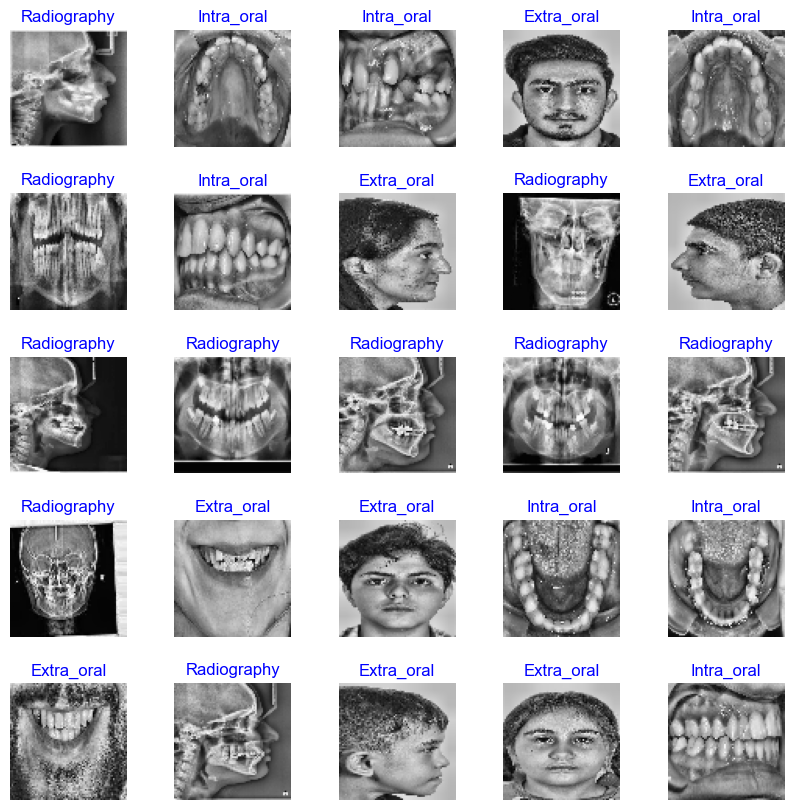

In [5]:
import numpy as np

import math

def show_images(gen):
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes)
    images, labels = next(gen)        # get a batch size samples from the generator
    
    length = len(labels)              # length of batch size
    rows = 5
    cols = 5
    figsize = (10, 10)
    
    sample = min(length, rows * cols)  # check if sample less than 25 images
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    for i, ax in enumerate(axes.flat):
        if i < sample:
            image = images[i] / 255       # scales data to range (0 - 255)
            ax.imshow(image)
            index = np.argmax(labels[i])  # get image index
            class_name = classes[index]   # get class of image
            ax.set_title(class_name, color='blue', fontsize=12)
        ax.axis('off')
    
    plt.show()
    
show_images(train_gen)

# Custom CNN with attention

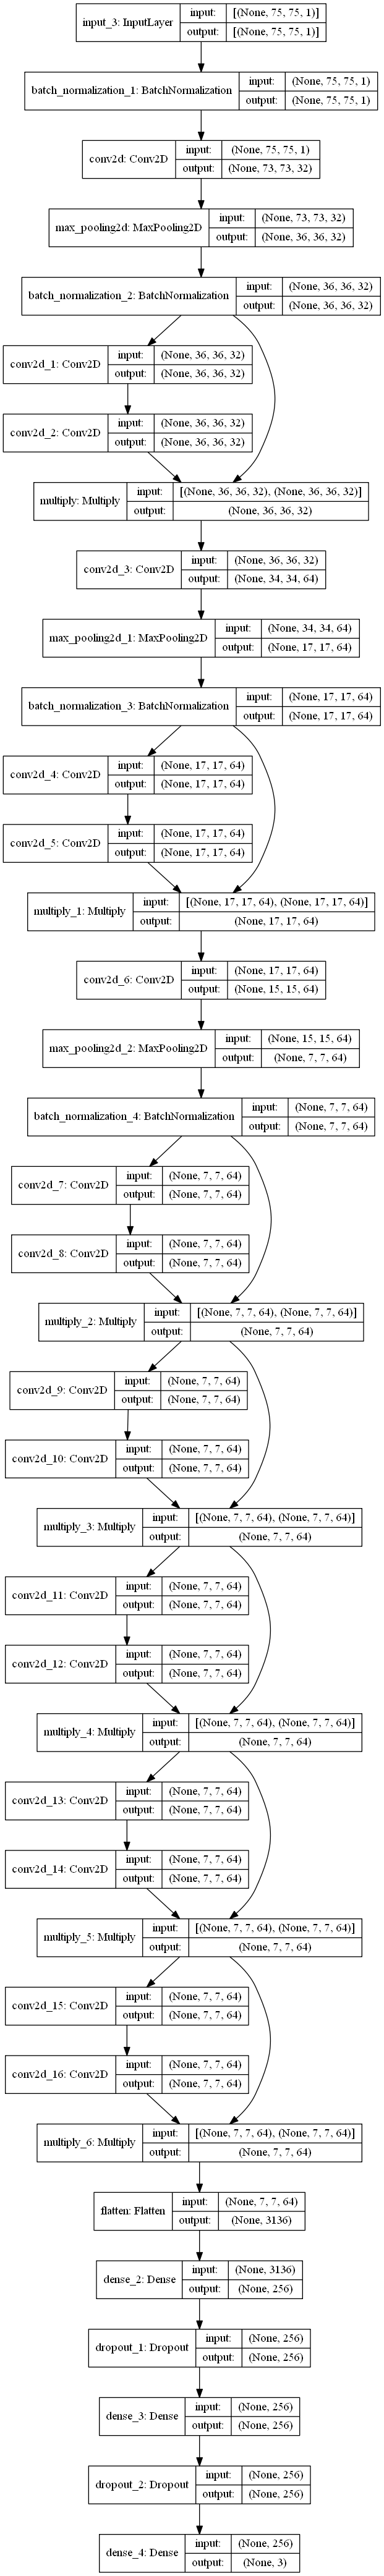

In [16]:
from tensorflow.keras import layers
from keras import optimizers


from tensorflow.keras.layers import Input, concatenate, multiply

img_size = (imsize, imsize)
channels = imchanel
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer


class Attention(layers.Layer):
    def __init__(self):
        super(Attention, self).__init__()

    def build(self, input_shape):
        self.WQ = self.add_weight(name="WQ", shape=(input_shape[-1], input_shape[-1]), initializer="random_normal", trainable=True)
        self.WK = self.add_weight(name="WK", shape=(input_shape[-1], input_shape[-1]), initializer="random_normal", trainable=True)
        self.WV = self.add_weight(name="WV", shape=(input_shape[-1], input_shape[-1]), initializer="random_normal", trainable=True)

    def call(self, inputs):
        q = tf.matmul(inputs, self.WQ)
        k = tf.matmul(inputs, self.WK)
        v = tf.matmul(inputs, self.WV)

        attention_weights = tf.nn.softmax(tf.matmul(q, k, transpose_b=True), axis=-1)
        output = tf.matmul(attention_weights, v)

        return output
    
def attention_module(inputs, filters):
    attention = layers.Conv2D(filters, kernel_size=1, activation='gelu')(inputs)
    attention = layers.Conv2D(filters, kernel_size=1, activation='sigmoid')(attention)
    attention = layers.multiply([inputs, attention])
    #attention = layers.MaxPooling2D(pool_size=(2, 2))(attention)
    return attention

def create_model(input_shape, class_count):
    input_tensor = layers.Input(shape=input_shape)

    # لایه‌های CNN سفارشی
    x = layers.BatchNormalization()(input_tensor)
    x = layers.Conv2D(32, (3, 3), activation='gelu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = attention_module(x, 32)
    x = layers.Conv2D(64, (3, 3), activation='gelu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = attention_module(x, 64)
    x = layers.Conv2D(64, (3, 3), activation='gelu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = attention_module(x, 64)
    x = attention_module(x, 64)
    x = attention_module(x, 64)
    x = attention_module(x, 64)
    x = attention_module(x, 64)
    #x = layers.Conv2D(64, kernel_size=1, activation='gelu')(x)
    #x = attention_module(x, 64)
    """
    # لایه‌های Self-Attention
    attention = layers.Attention()([x, x])
    attention = layers.Conv2D(64, kernel_size=1, activation='sigmoid')(attention)
    x = layers.multiply([x, attention])
    """
    
    """
        attention = layers.Attention()([x, x])
    attention = layers.Conv2D(64, kernel_size=1, activation='sigmoid')(attention)
    x = layers.multiply([x, attention])
    
    """

    # لایه‌های Dense
    x = layers.Flatten()(x)
    x = layers.Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
                     bias_regularizer=regularizers.l1(0.006), activation='gelu')(x)
    x = layers.Dropout(rate=0.45, seed=123)(x)
    x = layers.Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
                     bias_regularizer=regularizers.l1(0.006), activation='gelu')(x)
    x = layers.Dropout(rate=0.45, seed=123)(x)
    x = layers.Dense(class_count, activation='softmax')(x)

    model = tf.keras.models.Model(input_tensor, x)
    return model

model_incep = create_model(img_shape, class_count)
model_incep.compile(tf.keras.optimizers.Adam(learning_rate= 0.001), 
                    loss = 'categorical_crossentropy', 
                    metrics = ['accuracy'])



checkpoint_callback2 = keras.callbacks.ModelCheckpoint(
              filepath="gdrive/My Drive/...",
              monitor= 'val_accuracy', 
              verbose= 1,
              save_best_only= True, 
              mode = 'auto'
              );

callbacks = [MyCallback(model= model_incep, base_model= None, patience= patience,
            stop_patience= stop_patience, threshold= threshold, factor= factor,
            dwell= dwell, batches= batches, initial_epoch= 0, epochs= epochs, ask_epoch= ask_epoch )]

#model_incep.summary()
tf.keras.utils.plot_model(model_incep, show_shapes=True)






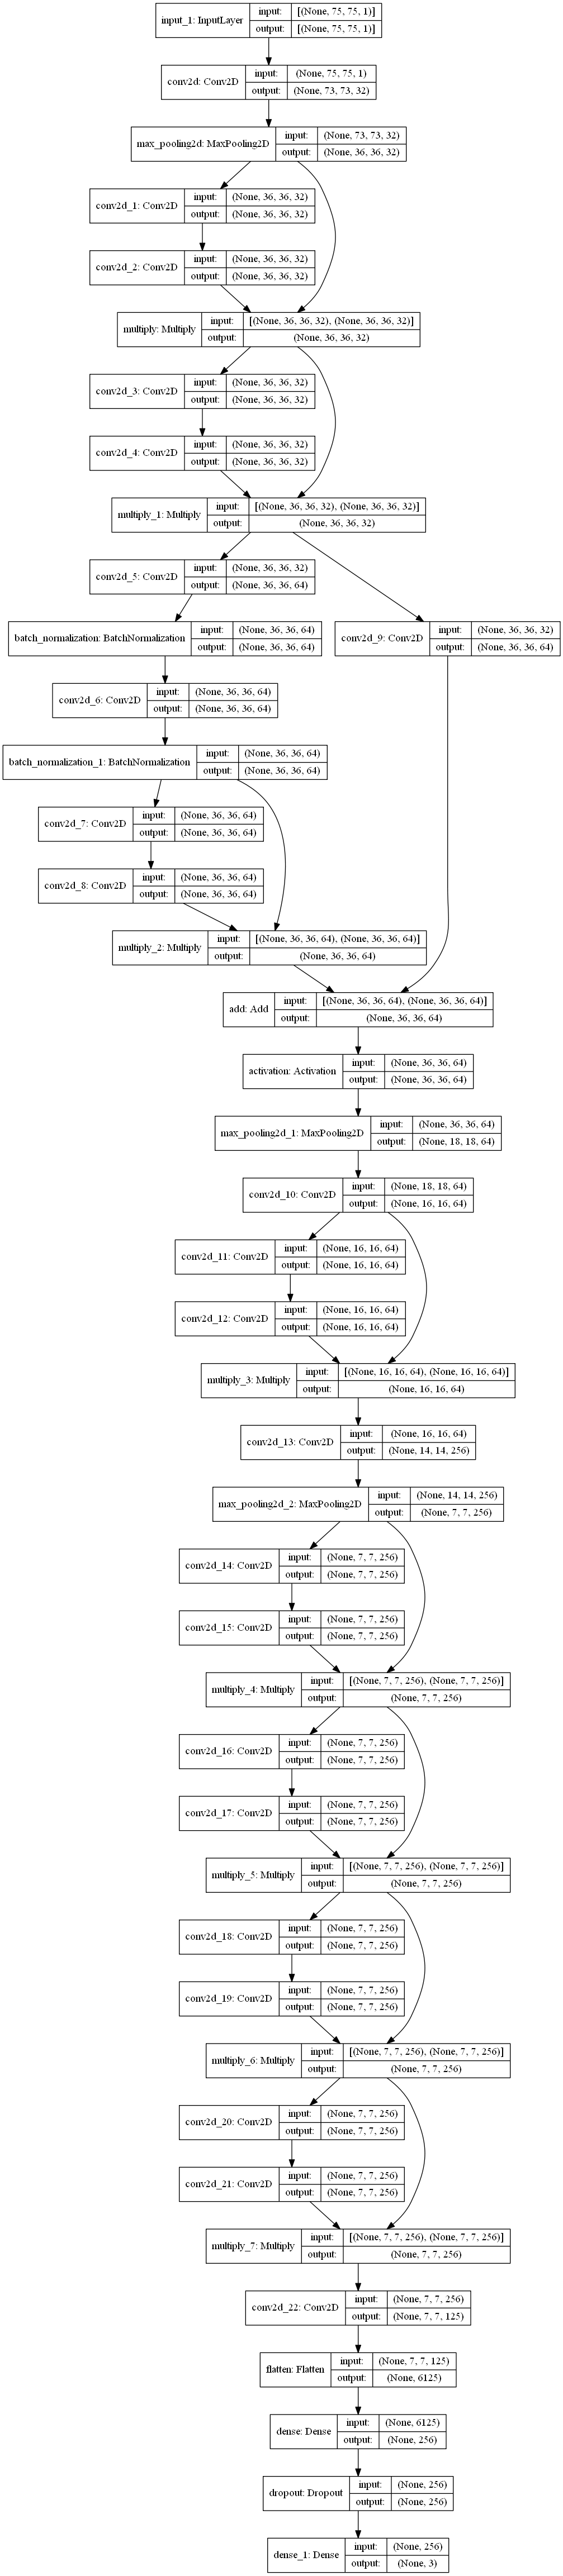

In [6]:
from tensorflow.keras import layers
from keras import optimizers


from tensorflow.keras.layers import Input, concatenate, multiply

img_size = (imsize, imsize)
channels = imchanel
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer


    
def attention_module(inputs, filters):
    attention = layers.Conv2D(filters, kernel_size=1, activation='relu')(inputs)
    attention = layers.Conv2D(filters, kernel_size=1, activation='sigmoid')(attention)
    attention = layers.multiply([inputs, attention])
    #attention = layers.MaxPooling2D(pool_size=(2, 2))(attention)
    return attention


def residual_block(x, filters, kernel_size):
    x_res = x
    x = layers.Conv2D(filters, kernel_size, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, kernel_size, activation=None, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = attention_module(x, filters)
    if x_res.shape[-1] != filters:
        x_res = layers.Conv2D(filters, (1, 1), activation=None, padding='same')(x_res)
    x = layers.add([x, x_res])
    x = layers.Activation('relu')(x)
    if x.shape[1] >= 2 and x.shape[2] >= 2:
        x = layers.MaxPooling2D((2, 2))(x)
    return x

def create_model(input_shape, class_count):
    input_tensor = layers.Input(shape=input_shape)

    # لایه‌های CNN سفارشی
    #x = layers.BatchNormalization()(input_tensor)
    x = layers.Conv2D(32, (3, 3), activation='relu')(input_tensor)
    x = layers.MaxPooling2D((2, 2))(x)
    x = attention_module(x, 32)
    x = attention_module(x, 32)
    x = residual_block(x, 64, (3, 3))
    
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    #x = layers.MaxPooling2D((2, 2))(x)
    x = attention_module(x, 64)
    x = layers.Conv2D(256, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = attention_module(x, 256)
    x = attention_module(x, 256)
    x = attention_module(x, 256)
    x = attention_module(x, 256)
    x = layers.Conv2D(125, (1, 1), activation='relu')(x)

    # لایه‌های Dense
    #x = layers.BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001)(x)
    x = layers.Flatten()(x)
    #x = layers.Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
                    # bias_regularizer=regularizers.l1(0.006), activation='gelu')(x)
    #x = layers.Dropout(rate=0.45, seed=123)(x)
    x = layers.Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
                     bias_regularizer=regularizers.l1(0.006), activation='gelu')(x)
    x = layers.Dropout(rate=0.45, seed=123)(x)
    x = layers.Dense(class_count, activation='softmax')(x)

    model = tf.keras.models.Model(input_tensor, x)
    return model

model_incep = create_model(img_shape, class_count)
model_incep.compile(tf.keras.optimizers.Adamax(), 
                    loss = 'categorical_crossentropy', 
                    metrics = ['accuracy'])

batch_size = 32

checkpoint_callback2 = keras.callbacks.ModelCheckpoint(
              filepath="gdrive/My Drive/...",
              monitor= 'val_accuracy', 
              verbose= 1,
              save_best_only= True, 
              mode = 'auto'
              );

callbacks = [MyCallback(model= model_incep, base_model= None, patience= patience,
            stop_patience= stop_patience, threshold= threshold, factor= factor,
            dwell= dwell, batches= batches, initial_epoch= 0, epochs= epochs, ask_epoch= ask_epoch )]

#model_incep.summary()
tf.keras.utils.plot_model(model_incep, show_shapes=True)






In [7]:
model_incep.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 75, 75, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 73, 73, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 36, 36, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 36, 36, 32)   1056        max_pooling2d[0][0]              
______________________________________________________________________________________________

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /100    0.138   99.949   0.13626  99.660   0.00100  0.00100  val_loss     0.00    20.80  
 2 /100    0.128   100.000  0.11713  100.000  0.00100  0.00100  val_loss    14.04    20.61  
 3 /100    0.117   100.000  0.10998  100.000  0.00100  0.00100  val_loss     6.11    20.45  
 4 /100    0.111   99.975   0.10342  100.000  0.00100  0.00100  val_loss     5.97    20.42  
 5 /100    0.103   100.000  0.10467  99.660   0.00100  0.00050  val_loss    -1.20    20.57  
enter H to halt training or an integer for number of epochs to run then ask again
h
training has been halted at epoch 5 due to user input
training elapsed time was 0.0 hours,  1.0 minutes, 55.17 seconds)


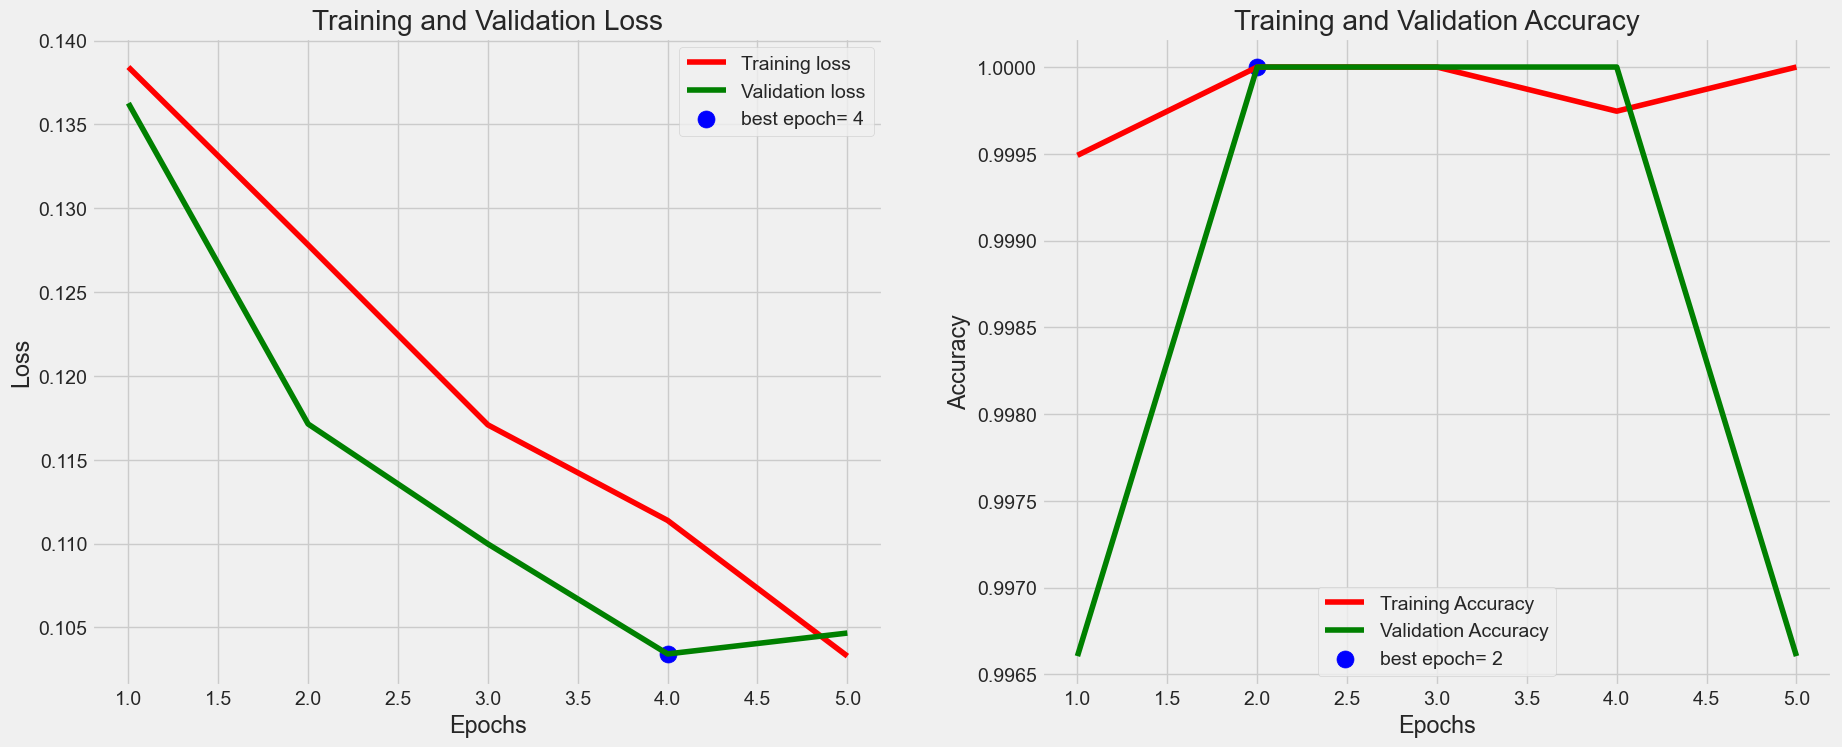

In [31]:
history = model_incep.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= callbacks,
                    validation_data= valid_gen, validation_steps= None, shuffle= False,
                    initial_epoch= 0)
plot_training(history)


# 5fold CV

Running fold 1...
Found 3536 validated image filenames belonging to 3 classes.
Found 885 validated image filenames belonging to 3 classes.
Found 492 validated image filenames belonging to 3 classes.
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /10     2.659   85.860   1.18116  98.305   0.00100  0.00100  accuracy     0.00    23.53  
 2 /10     0.833   99.406   0.62790  98.305   0.00100  0.00100  val_loss    46.84    19.87  
 3 /10     0.460   99.802   0.36526  99.774   0.00100  0.00100  val_loss    41.83    19.49  
 4 /10     0.304   99.830   0.25600  99.887   0.00100  0.00100  val_loss    29.91    19.69  
 5 /10     0.215   100.000  0.19769  99.887   0.00100  0.00100  val_loss    22.78    19.68   
 6 /10     0.170   100.000  0.15302  99.887   0.00100  0.00100  val_loss    22.60    19.97   
 7 /10     0.144   100.000  0.12699  99.887   0.00100  0.00100  val_loss    17.01    19.89   
 8 /10     0.129   100.000  0.12045  99.774   0.00100  

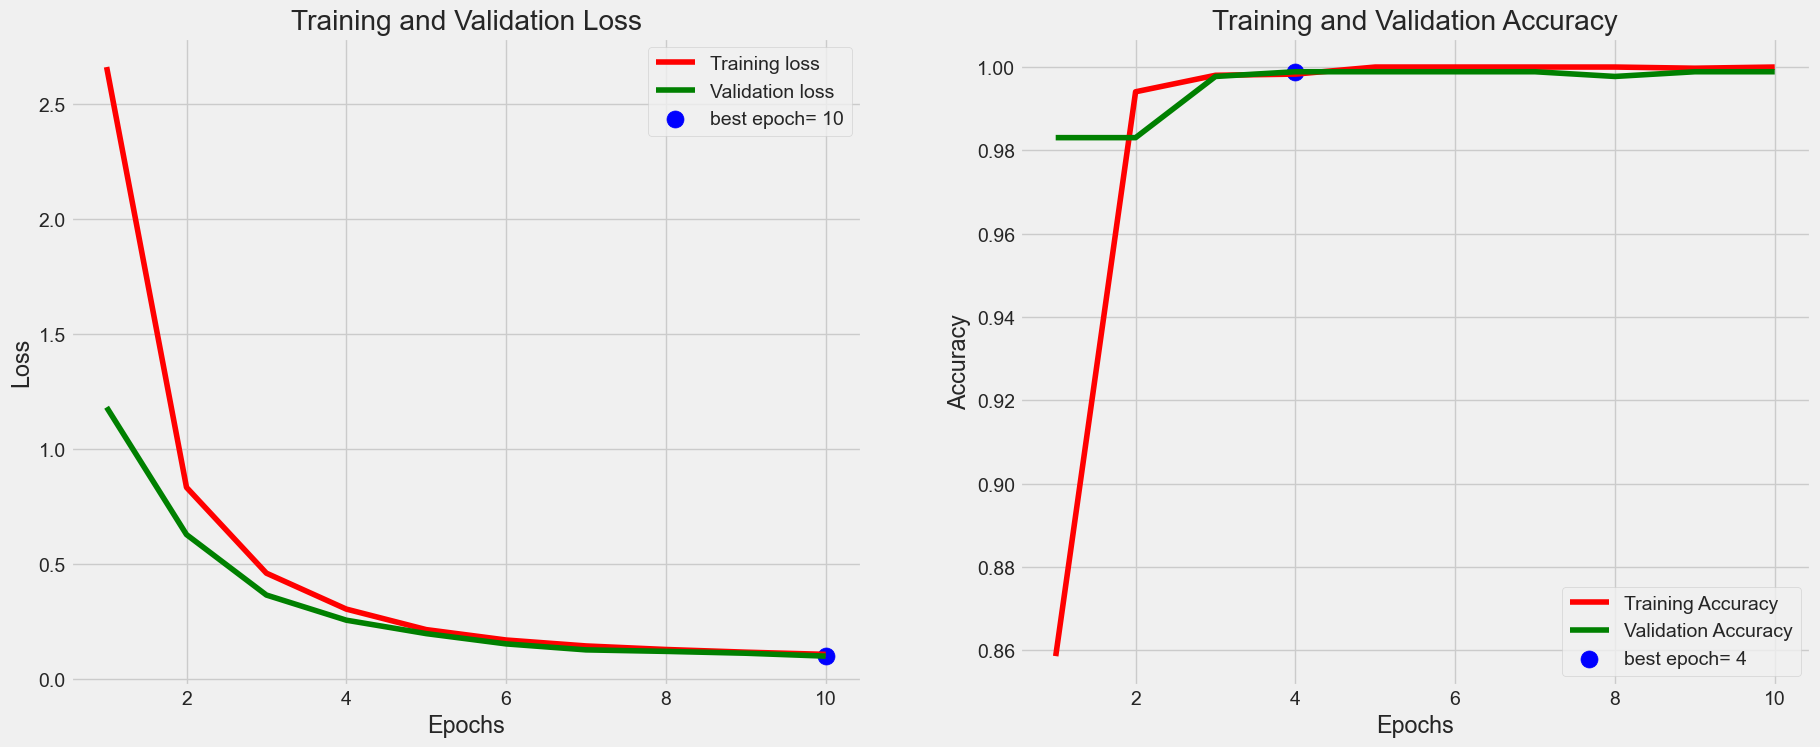

Accuracy at the end of fold 1 : 0.9988700747489929
Loss at the end of fold 1 : 0.09982447326183319
Running fold 2...
Found 3537 validated image filenames belonging to 3 classes.
Found 884 validated image filenames belonging to 3 classes.
Found 492 validated image filenames belonging to 3 classes.
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /10     1.853   91.886   0.64674  98.982   0.00100  0.00100  val_loss     0.00    23.06  
 2 /10     0.456   99.152   0.30843  99.774   0.00100  0.00100  val_loss    52.31    19.97  
 3 /10     0.256   99.830   0.21277  99.887   0.00100  0.00100  val_loss    31.01    19.91  
 4 /10     0.185   99.887   0.16194  99.887   0.00100  0.00100  val_loss    23.89    19.82  
 5 /10     0.150   99.972   0.13456  99.887   0.00100  0.00100  val_loss    16.90    20.22  
 6 /10     0.130   100.000  0.12955  99.887   0.00100  0.00100  val_loss     3.73    20.03   
 7 /10     0.118   99.972   0.10978  99.887   0.001

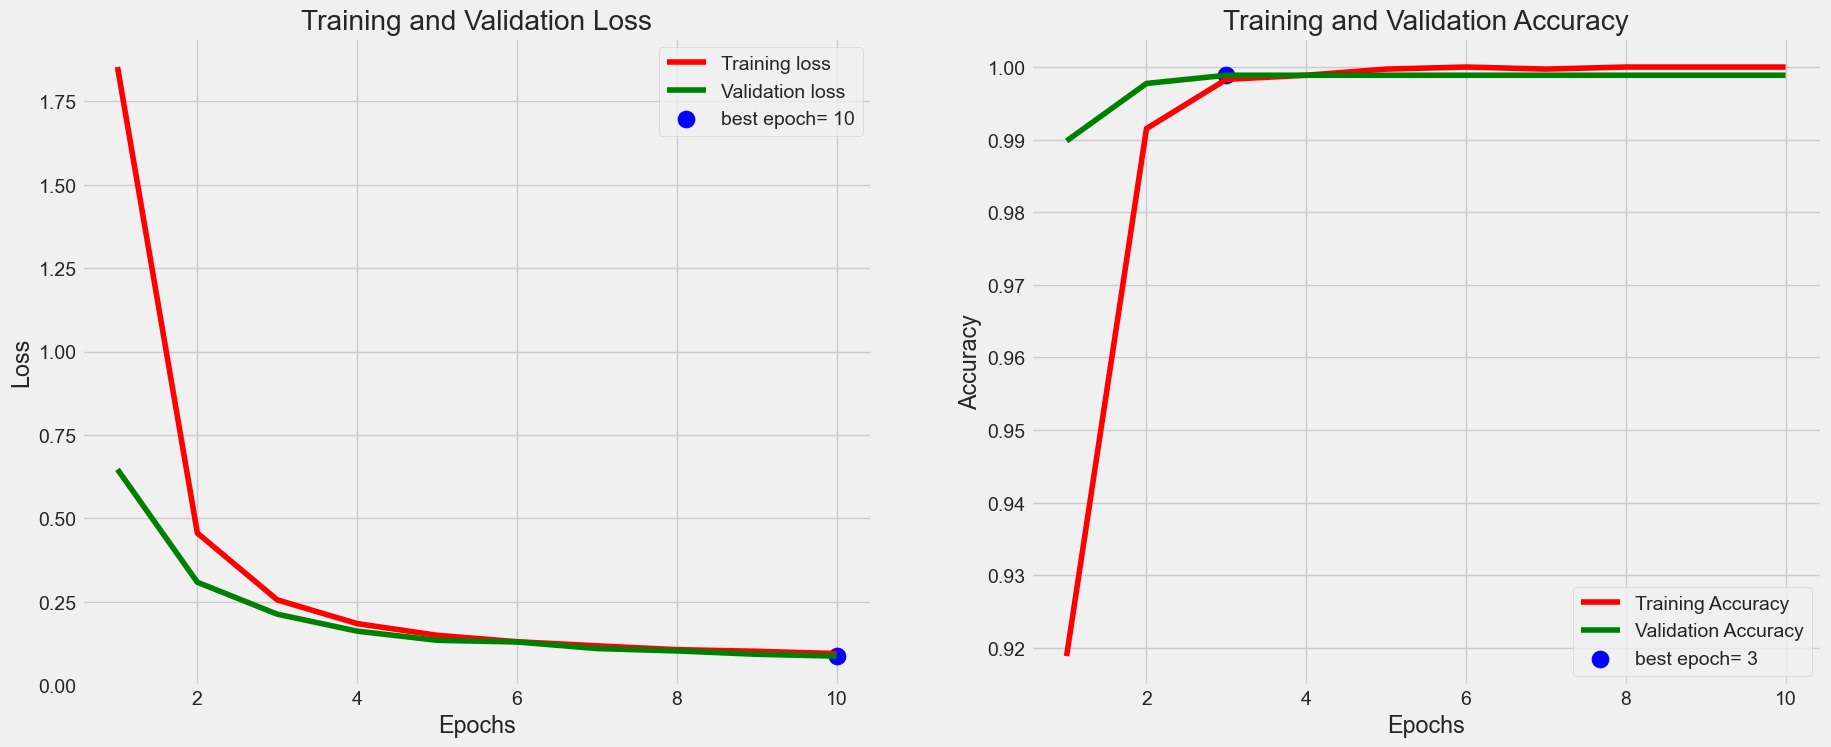

Accuracy at the end of fold 2 : 0.9988687634468079
Loss at the end of fold 2 : 0.08706161379814148
Running fold 3...
Found 3537 validated image filenames belonging to 3 classes.
Found 884 validated image filenames belonging to 3 classes.
Found 492 validated image filenames belonging to 3 classes.
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /10     2.387   87.334   0.93234  99.095   0.00100  0.00100  accuracy     0.00    22.08  
 2 /10     0.662   99.095   0.44173  99.661   0.00100  0.00100  val_loss    52.62    19.92  
 3 /10     0.357   99.632   0.32552  98.643   0.00100  0.00100  val_loss    26.31    19.83  
 4 /10     0.237   99.774   0.21307  99.887   0.00100  0.00100  val_loss    34.54    19.81  
 5 /10     0.178   99.972   0.15061  99.774   0.00100  0.00100  val_loss    29.32    19.93  
 6 /10     0.143   100.000  0.13050  99.774   0.00100  0.00100  val_loss    13.35    20.07   
 7 /10     0.130   99.972   0.10998  99.887   0.001

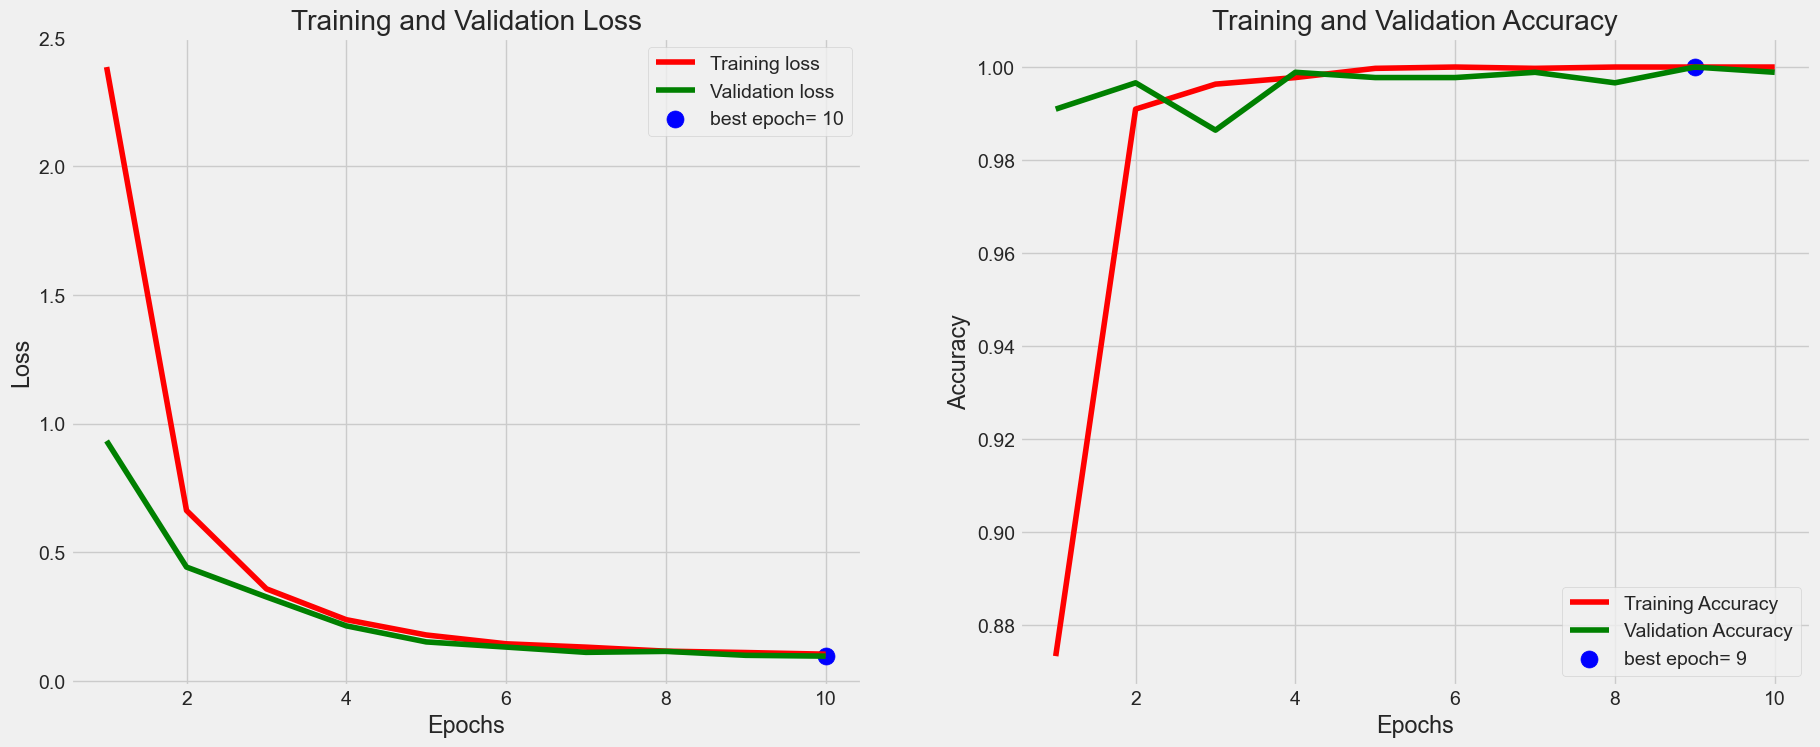

Accuracy at the end of fold 3 : 0.9988687634468079
Loss at the end of fold 3 : 0.09529845416545868
Running fold 4...
Found 3537 validated image filenames belonging to 3 classes.
Found 884 validated image filenames belonging to 3 classes.
Found 492 validated image filenames belonging to 3 classes.
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /10     2.269   87.560   0.83002  98.982   0.00100  0.00100  accuracy     0.00    22.13  
 2 /10     0.563   99.237   0.39092  99.208   0.00100  0.00100  val_loss    52.90    20.11  
 3 /10     0.304   99.830   0.24921  99.321   0.00100  0.00100  val_loss    36.25    19.86  
 4 /10     0.208   99.915   0.21666  98.869   0.00100  0.00100  val_loss    13.06    19.86  
 5 /10     0.174   99.802   0.15435  99.434   0.00100  0.00100  val_loss    28.76    19.78  
 6 /10     0.140   100.000  0.13437  99.095   0.00100  0.00100  val_loss    12.94    20.23   
 7 /10     0.123   100.000  0.11661  99.774   0.001

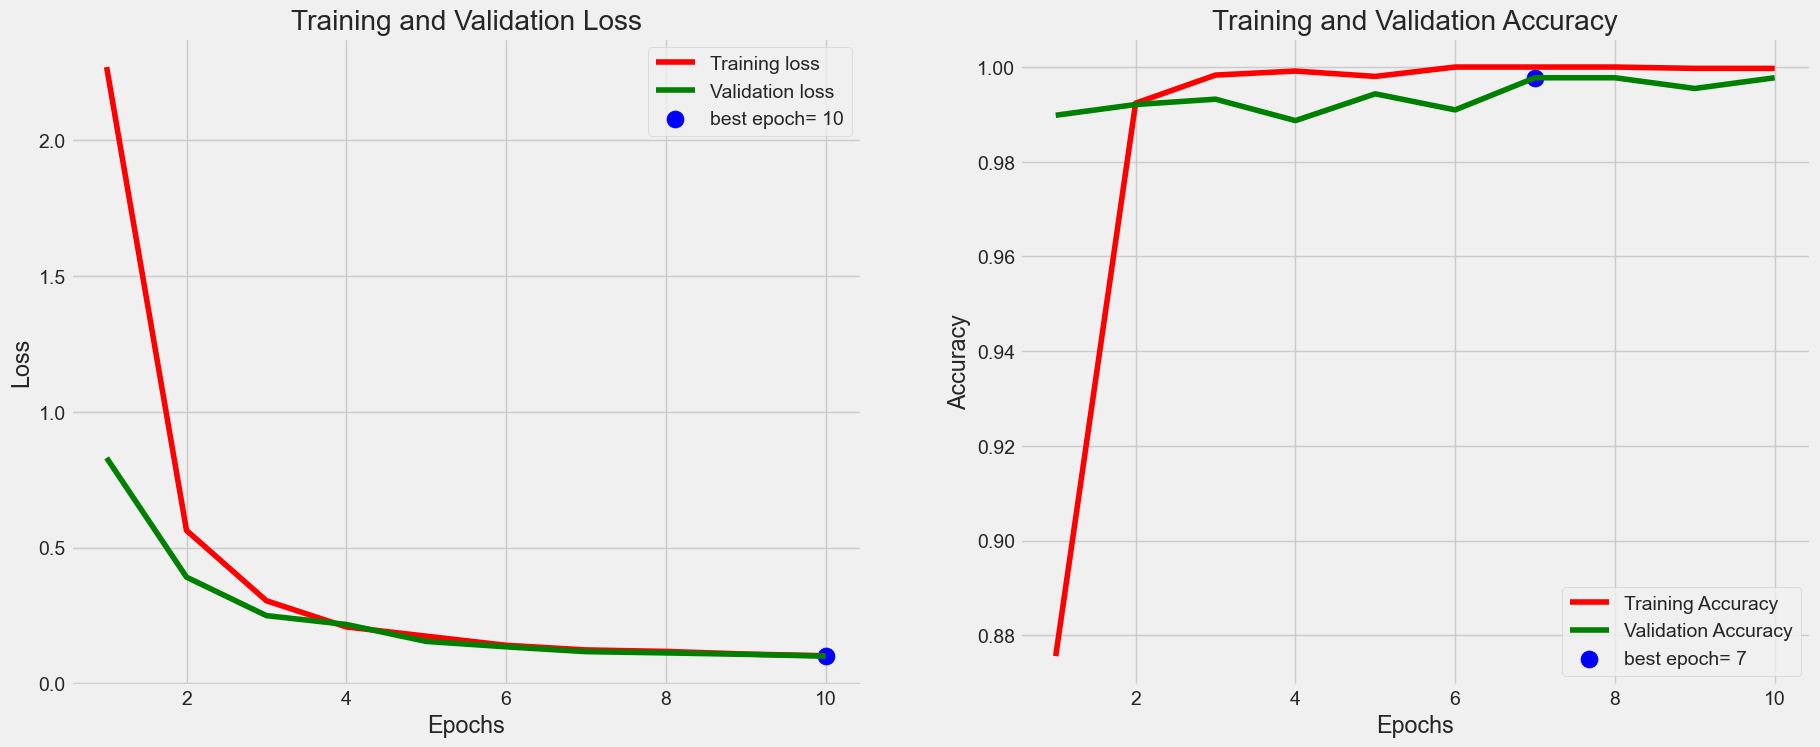

Accuracy at the end of fold 4 : 0.9977375268936157
Loss at the end of fold 4 : 0.10005291551351547
Running fold 5...
Found 3537 validated image filenames belonging to 3 classes.
Found 884 validated image filenames belonging to 3 classes.
Found 492 validated image filenames belonging to 3 classes.
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /10     2.817   86.853   1.15568  98.982   0.00100  0.00100  accuracy     0.00    21.87  
 2 /10     0.789   99.180   0.51245  99.661   0.00100  0.00100  val_loss    55.66    19.91  
 3 /10     0.396   99.746   0.29836  99.887   0.00100  0.00100  val_loss    41.78    20.05  
 4 /10     0.257   99.717   0.21546  99.661   0.00100  0.00100  val_loss    27.79    20.41  
 5 /10     0.183   99.972   0.15995  99.774   0.00100  0.00100  val_loss    25.76    19.71  
 6 /10     0.148   100.000  0.13733  99.774   0.00100  0.00100  val_loss    14.14    19.91   
 7 /10     0.131   100.000  0.12282  99.548   0.001

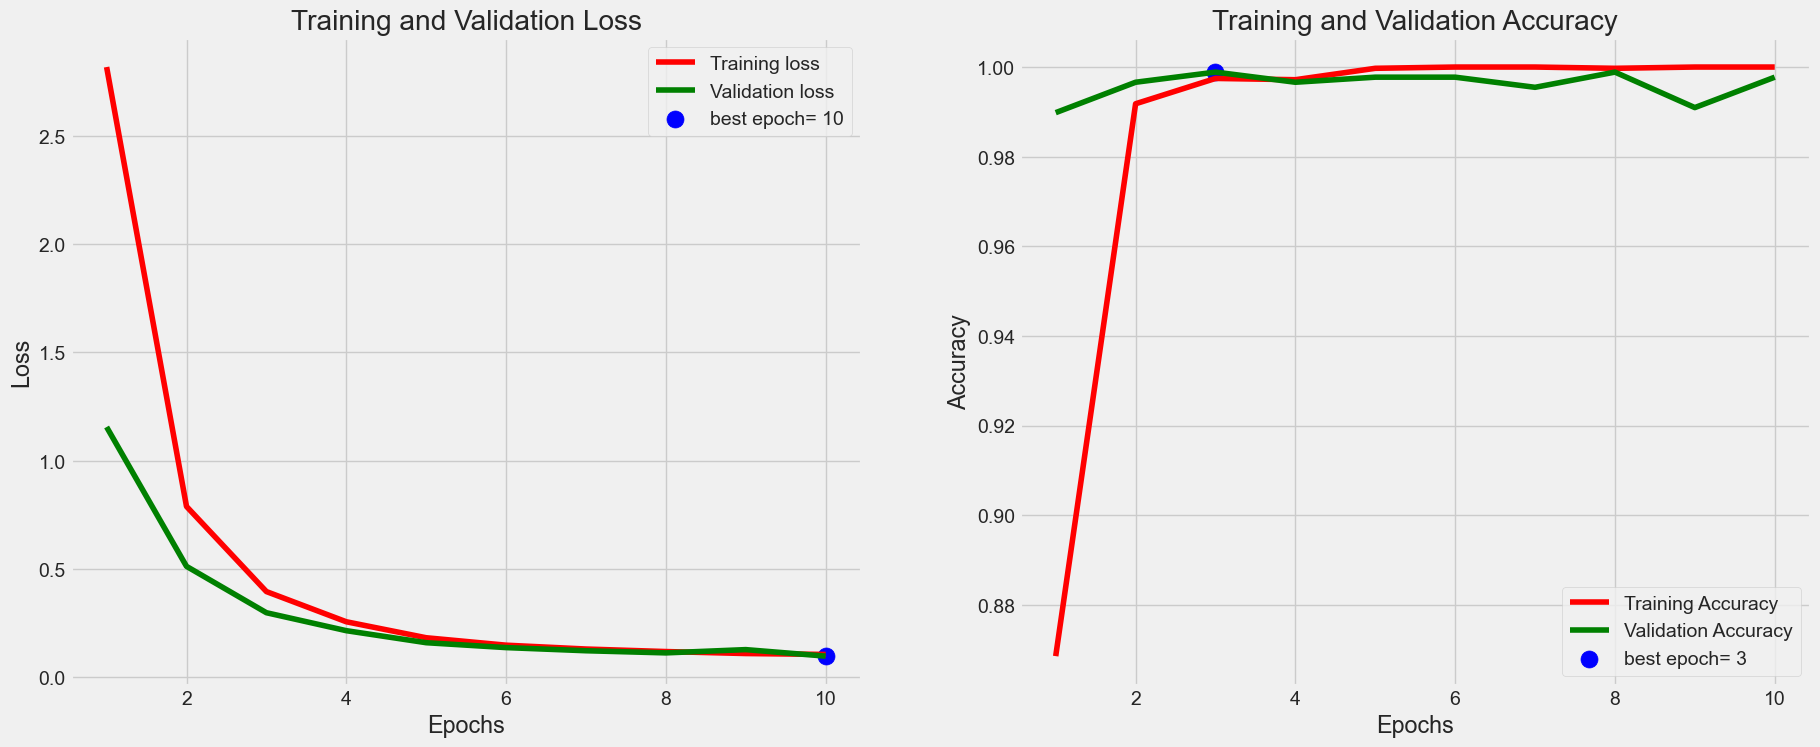

Accuracy at the end of fold 5 : 0.9977375268936157
Loss at the end of fold 5 : 0.09795650839805603
Mean accuracy across folds: 0.9984165310859681
Mean loss across folds: 0.09603879302740097
Confidence Interval for accuracy: (0.9968772565697732, 0.9999558056021629)
Confidence Interval for loss: (0.08270838439628368, 0.10936920165851825)


In [50]:
import numpy as np
from sklearn.model_selection import KFold
import gc


main_df, test_df = train_test_split(df,  train_size= 0.9, shuffle= True, random_state= 123)

# تعریف متغیرها و پارامتر‌ها
batch_size = 20
epochs = 10
patience = 1
stop_patience = 10
threshold = 0.9
factor = 0.5
dwell = True
freeze = False
ask_epoch = 20
batches = int(np.ceil(len(train_gen.labels) / batch_size))

checkpoint_callback2 = keras.callbacks.ModelCheckpoint(
    filepath="gdrive/My Drive/...",
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='auto'
)




# تقسیم داده‌ها به فولدها
kfold = KFold(n_splits=5, shuffle=True, random_state=123)

fold_results_accuracy = []  # لیستی برای ذخیره مقادیر دقت
fold_results_loss = []  # لیستی برای ذخیره مقادیر لاس

for fold, (train_index, valid_index) in enumerate(kfold.split(main_df), 1):
    print(f"Running fold {fold}...")

    train_df2 = main_df.iloc[train_index]
    valid_df2 = main_df.iloc[valid_index]
    train_gen, valid_gen, _ = create_gens(train_df2, valid_df2, test_df, batch_size)

    
    model_incep = create_model(img_shape, class_count)
    model_incep.compile(tf.keras.optimizers.Adamax(learning_rate= 0.001), 
                    loss = 'categorical_crossentropy', 
میانگین لاس اعتبارسنجی در پایان فولد

    gc.collect()
# محاسبه میانگین نهایی
mean_accuracy = np.mean(fold_results_accuracy)
mean_loss = np.mean(fold_results_loss)
print("Mean accuracy across folds:", mean_accuracy)
print("Mean loss across folds:", mean_loss)


from scipy.stats import t

confidence = 0.95  # سطح اطمینان مورد نظر (مثلاً 0.95 برای 95%)
n_folds = len(fold_results_accuracy)  # تعداد فولدها

# محاسبه میانه و انحراف معیار دقت و لاس
mean_accuracy = np.mean(fold_results_accuracy)
mean_loss = np.mean(fold_results_loss)
std_accuracy = np.std(fold_results_accuracy)
std_loss = np.std(fold_results_loss)

# محاسبه فاصله اطمینان برای دقت
confidence_interval_accuracy = t.interval(confidence, n_folds - 1, loc=mean_accuracy, scale=std_accuracy)

# محاسبه فاصله اطمینان برای لاس
confidence_interval_loss = t.interval(confidence, n_folds - 1, loc=mean_loss, scale=std_loss)

print("Confidence Interval for accuracy:", confidence_interval_accuracy)
print("Confidence Interval for loss:", confidence_interval_loss)

# Pre_trained models

In [5]:
img_size = (imsize, imsize)
channels = imchanel
img_shape = (img_size[0], img_size[1], 3)
base_model = tf.keras.applications.InceptionV3(include_top= False, input_shape= img_shape, pooling= 'max')  #23M

In [ ]:
base_model = tf.keras.applications.Xception(include_top= False, input_shape= img_shape, pooling= 'max')

14082048/83683744 [====>.........................] - ETA: 38:58

In [ ]:
from tensorflow.keras import layers
from keras import optimizers
img_size = (imsize, imsize)
channels = imchanel
img_shape = (img_size[0], img_size[1], 3)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer


#base_model = tf.keras.applications.efficientnet.EfficientNetB5(include_top= False, input_shape= img_shape, pooling= 'max')  #22M
#base_model = tf.keras.applications.ResNet50(include_top= False, input_shape= img_shape, pooling= 'max')  #23M
base_model = tf.keras.applications.InceptionV3(include_top= False, input_shape= img_shape, pooling= 'max')  #23M
#base_model = tf.keras.applications.Xception(include_top= False, input_shape= img_shape, pooling= 'max')  #22M


x = layers.BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001)(base_model.output)
x = layers.Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu')(x)
x = layers.Dropout(rate= 0.45, seed= 123)(x)                
x = layers.Dense(class_count, activation= 'softmax')(x)  

model_incep = tf.keras.models.Model(base_model.input, x)
model_incep.compile(tf.keras.optimizers.Adamax(), 
                    loss = 'categorical_crossentropy', 
                    metrics = ['accuracy'])



checkpoint_callback2 = keras.callbacks.ModelCheckpoint(
              filepath="gdrive/My Drive/...",
              monitor= 'val_accuracy', 
              verbose= 1,
              save_best_only= True, 
              mode = 'auto'
              );

callbacks = [MyCallback(model= model_incep, base_model= base_model, patience= patience,
            stop_patience= stop_patience, threshold= threshold, factor= factor,
            dwell= dwell, batches= batches, initial_epoch= 0, epochs= epochs, ask_epoch= ask_epoch )]

history = model_incep.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= callbacks,
                    validation_data= valid_gen, validation_steps= None, shuffle= False,
                    initial_epoch= 0)
plot_training(history)




In [ ]:
history = model_incep.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= callbacks,
                    validation_data= valid_gen, validation_steps= None, shuffle= False,
                    initial_epoch= 0)
plot_training(history)


# Evaluation

197/197 [==============================] - 4s 18ms/step - loss: 0.4563 - accuracy: 1.0000
Train Loss:  0.4435182511806488
Train Accuracy:  1.0
--------------------
Validation Loss:  0.4918389916419983
Validation Accuracy:  1.0
--------------------
Test Loss:  0.4563167691230774
Test Accuracy:  1.0


C:\Users\drsha\anaconda3\envs\az2\lib\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix, Without Normalization
[[105   0   0]
 [  0 160   0]
 [  0   0 129]]
              precision    recall  f1-score   support

 Radiography       1.00      1.00      1.00       105
  Extra_oral       1.00      1.00      1.00       160
  Intra_oral       1.00      1.00      1.00       129

    accuracy                           1.00       394
   macro avg       1.00      1.00      1.00       394
weighted avg       1.00      1.00      1.00       394



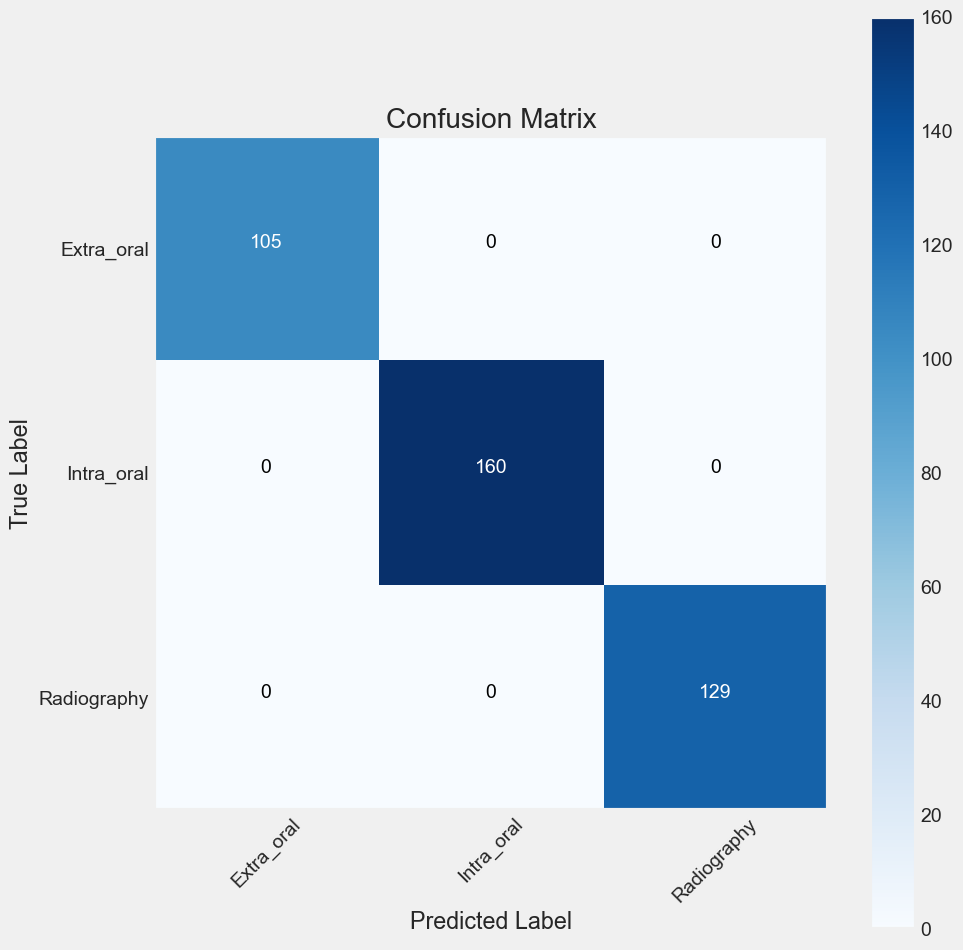

In [10]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
train_score = model_incep.evaluate(train_gen, steps= 4, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

preds = model_incep.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

target_names = ['Extra_oral','Intra_oral','Radiography']
# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= labels))

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import cohen_kappa_score
import numpy as np

y_pred = model_incep.predict_generator(test_gen)
y_pred_argmax = np.argmax(y_pred, axis=-1)
accuracy = round(accuracy_score(test_gen.classes, y_pred_argmax),2)
precision = round(precision_score(test_gen.classes, y_pred_argmax, average='macro'), 2)
recall = round(recall_score(test_gen.classes, y_pred_argmax, average='macro'), 2)
f1 = round(f1_score(test_gen.classes, y_pred_argmax, average='macro'), 2)
y_pred = model_incep.predict(test_gen)
y_pred_argmax = np.argmax(y_pred, axis=-1)
num_classes = len(test_gen.class_indices)
test_labels = np.zeros((len(test_gen.classes), num_classes))
test_labels[np.arange(len(test_gen.classes)), test_gen.classes] = 1
kappa = cohen_kappa_score(test_labels.argmax(axis=-1), y_pred_argmax)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1:', f1)
print('Cohen\'s kappa:', kappa)

C:\Users\drsha\anaconda3\envs\az2\lib\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0
Cohen's kappa: 1.0


In [34]:
from tensorflow.keras.utils import to_categorical
test_labels_categorical = to_categorical(test_gen.classes, num_classes=num_classes)
def log_loss(y_true, y_pred):
    N0 = np.sum(y_true == 0)
    N1 = np.sum(y_true == 1)
    
    loss = (-1/N0) * np.sum(y_true[y_true == 0] * np.log(y_pred[y_true == 0])) - (1/N1) * np.sum(y_true[y_true == 1] * np.log(y_pred[y_true == 1]))
    
    return loss


loss = log_loss(test_labels_categorical, y_pred)
print("Log Loss:", loss)

Log Loss: 0.011612299130047637


# ROC

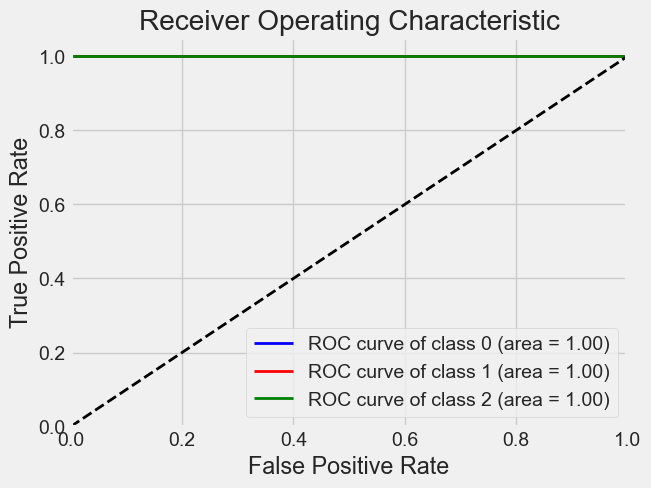

In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
y_scores = model_incep.predict(test_gen)


y_true = np.zeros((len(test_gen.classes), num_classes))
y_true[np.arange(len(test_gen.classes)), test_gen.classes] = 1

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
plt.figure()
colors = ['blue', 'red', 'green']  # رنگ‌های مختلف برای هر دسته
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # خط مرجع برای مقایسه
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

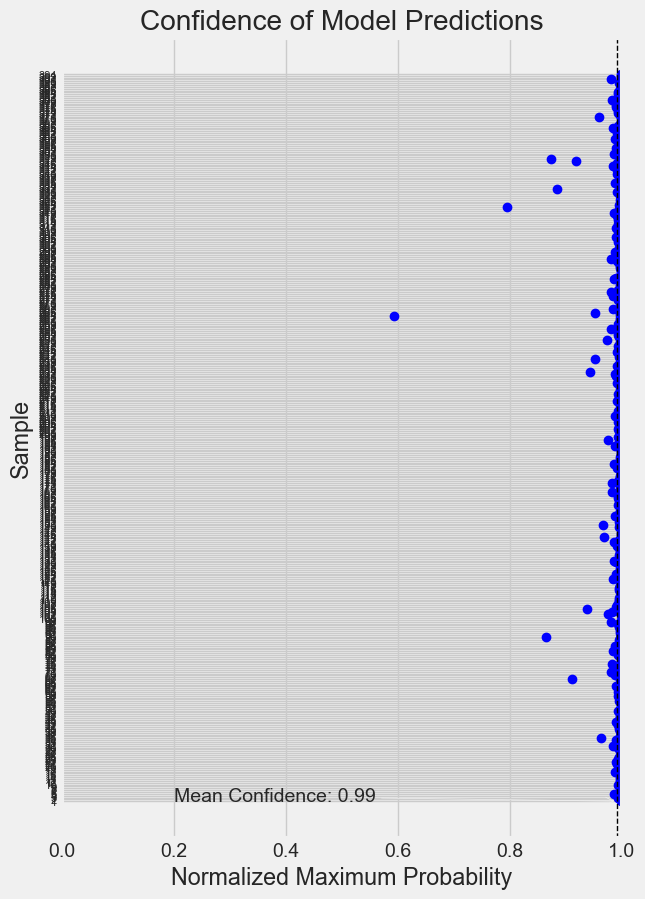

In [54]:
import matplotlib.pyplot as plt

y_pred = model_incep.predict(test_gen)
y_pred_argmax = np.argmax(y_pred, axis=-1)
y_pred_prob = np.max(y_pred, axis=1) # حداکثر احتمال در پیش‌بینی
y_pred_prob_normalized = y_pred_prob / np.sum(y_pred, axis=1) # نرمالیزه کردن احتمالات

# رسم نمودار
fig, ax = plt.subplots(figsize=(8, 10))  # تغییر اندازه نمودار
plt.plot(y_pred_prob_normalized, range(len(test_gen.classes)), 'bo') # نمودار نمونه‌ها با رنگ آبی

# نشان دادن موارد اشتباه با رنگ قرمز
misclassified_indices = np.where(y_pred_argmax != test_gen.classes)[0]
for misclassified_index in misclassified_indices:
    plt.plot(y_pred_prob_normalized[misclassified_index], misclassified_index, 'ro')

plt.xlabel('Normalized Maximum Probability')
plt.ylabel('Sample')
plt.title('Confidence of Model Predictions')

# تنظیم شماره‌های نمونه‌ها
sample_labels = [str(i+1) for i in range(len(test_gen.classes))]
plt.yticks(range(len(test_gen.classes)), sample_labels, fontsize=8)

plt.xlim([0, 1])
plt.grid(True)
mean_confidence = np.mean(y_pred_prob_normalized)
plt.axvline(x=mean_confidence, color='black', linestyle='--', linewidth=1, label='میانگین اطمینان')

# تنظیم ارتفاع و عرض نمودار
plt.subplots_adjust(left=0.2, bottom=0.1, right=0.9, top=0.9)  # تغییر اندازه نمودار با تابع subplots_adjust

# نوشتن مقدار تقاطع خط چین با محور افقی
plt.annotate(f'Mean Confidence: {mean_confidence:.2f}', xy=(mean_confidence, 0), xytext=(0.2, -0.2),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.show()

# Misclassified Images

IndexError: too many indices for array: array is 2-dimensional, but 4 were indexed

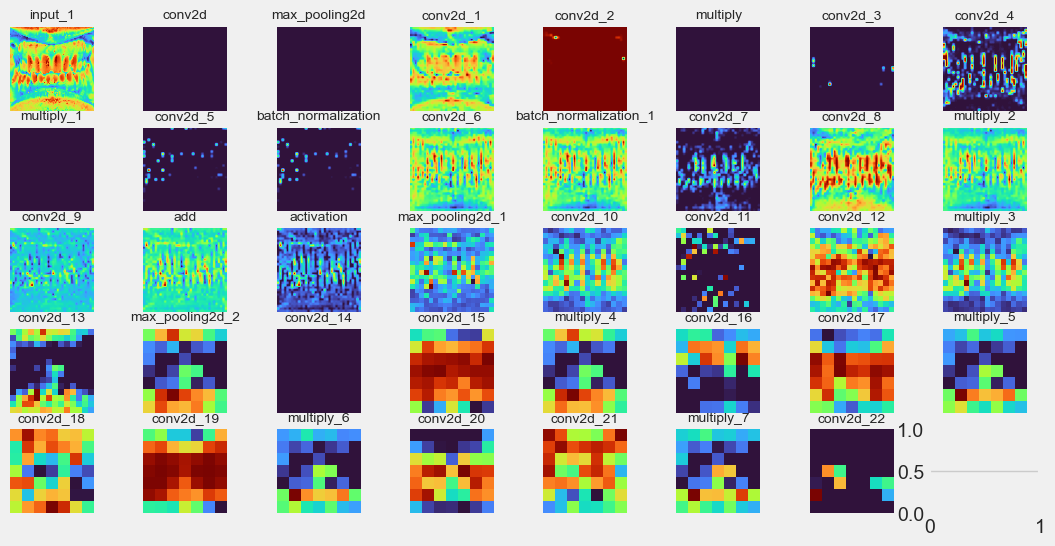

In [29]:
layer_indices = list(range(len(model_incep.layers)))
from tensorflow.keras import models
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import random
import os
import numpy as np

fig, axes = plt.subplots(nrows=5, ncols=8, figsize=(12, 6))
layer_indices = list(range(len(model_incep.layers)))
layer_outputs = [model_incep.layers[i].output for i in layer_indices]

activation_model = models.Model(inputs=model_incep.input, outputs=layer_outputs)

batch, _ = train_gen.next()
img_idx = random.choice(range(batch.shape[0]))
x = batch[img_idx]
img_path = train_gen.filepaths[img_idx]
activations = activation_model.predict(np.expand_dims(x, axis=0))


plt.suptitle(os.path.basename(img_path))
plt.tight_layout()

# Add image path to the figure
plt.text(0.5, -0.1, img_path, ha='center', transform=fig.transFigure)
plt.show()

In [2]:
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
labels = ['Extra_oral','Intra_oral','Radiography']
test_labels_categorical = to_categorical(test_gen.classes, num_classes=num_classes)
y_pred_labels = np.argmax(y_pred, axis=1)
test_classes_labels = np.argmax(test_labels_categorical, axis=1)

misclassified_images = []
for i in range(len(test_gen.filenames)):
    if np.not_equal(test_classes_labels[i], y_pred_labels[i]):
        misclassified_images.append(test_gen.filenames[i])

print("Misclassified Images:")
for image_path in misclassified_images:
    i = test_gen.filenames.index(image_path)  # پیدا کردن شاخص متفاوت مربوط به عکس
    # نمایش عکس‌های به اشتباه تشخیص داده شده
    img = plt.imread(image_path)
    plt.grid(None)
    plt.axis('off')
    plt.imshow(img)
    plt.text(0, -10, f"Predicted: {labels[y_pred_labels[i]]}", fontsize=12, color='red')
    plt.text(0, -30, f"Actual: {labels[test_classes_labels[i]]}", fontsize=12, color='blue')
    plt.text(0, -50, f"y_pred: {labels[np.argmax(y_pred[i])]} ({np.max(y_pred[i])*100:.2f}% confidence)",
             fontsize=10, color='green')
    plt.text(0, -70, f"Image Path: {image_path}", fontsize=10, color='black')
    plt.show()

NameError: name 'test_gen' is not defined

# GRAD CAM

In [9]:
last_conv_layer = None
classifier_layers = []
layer_names = []
#image_orginal = cv2.imread('images/Left_occlusion/image_4_tyh1epwe1du.jpg')


for layer in reversed(model_incep.layers):
    if 'conv' in layer.name:
        last_conv_layer = layer
        break

if last_conv_layer is None:
    print("هیچ لایه کانولوشنی در مدل یافت نشد.")
else:
    print("آخرین لایه کانولوشنی: ", last_conv_layer.name)

found_last_conv = False


if len(classifier_layers) == 0:
    print("هیچ لایه‌ای بعد از آخرین لایه کانولوشنی یافت نشد.")
else:
    print("لایه‌های بعد از آخرین لایه کانولوشنی:")
    for layer in classifier_layers:
        layer_names.append(layer.name)
    layer_names.pop(0)  # حذف اولین عنصر
    print(layer_names)

آخرین لایه کانولوشنی:  conv2d_16
لایه‌های بعد از آخرین لایه کانولوشنی:
['flatten', 'dense', 'dropout', 'dense_1', 'dropout_1', 'dense_2']


In [6]:
['Front_occlusion','Frontal','Frontal_smile',
 'Lat_ceph','Left_occlusion','Lower_arch','OPG',
 'PA_ceph','Profile','Profile_left','Right_occlusion', 'Upper_arch']


['Front_occlusion',
 'Frontal',
 'Frontal_smile',
 'Lat_ceph',
 'Left_occlusion',
 'Lower_arch',
 'OPG',
 'PA_ceph',
 'Profile',
 'Profile_left',
 'Right_occlusion',
 'Upper_arch']

In [1]:

image_dir = 'test/'
image_list = os.listdir(image_dir)
random_image = random.choice(image_list)
image_orginal = cv2.imread(os.path.join(image_dir, random_image))


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap, top_pred_index.numpy()

def superimposed_img(image, heatmap):
    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]



last_conv_layer_name = last_conv_layer.name
#last_conv_layer_name = 'multiply_20'


classifier_layer_names = layer_names
img = image_orginal
img = cv2.resize(img, (imsize, imsize),interpolation=cv2.INTER_NEAREST)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#img = img / 255.0
plt.grid(None)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
heatmap, top_index = make_gradcam_heatmap(img, model_incep, last_conv_layer_name, classifier_layer_names)
#print("predicted as", labels[top_index])
plt.matshow(heatmap)
plt.grid(None)
plt.show()

import matplotlib.cm as cm
s_img = superimposed_img(img[0], heatmap)
plt.grid(None)
plt.imshow(s_img)
plt.colorbar(cmap='jet')




gradcam_heatmap = heatmap

# خواندن تصویر اصلی
image = image_orginal
#image = cv2.resize(image, (224, 224))

# تغییر اندازه gradcam_heatmap برابر با اندازه تصویر اصلی
gradcam_heatmap_resized = cv2.resize(gradcam_heatmap, (image.shape[1], image.shape[0]))

# مقیاس‌بندی gradcam_heatmap بین 0 و 255
gradcam_heatmap_scaled = np.uint8(255 * gradcam_heatmap_resized)

# اعمال gradcam_heatmap بر روی تصویر اصلی
heatmap = cv2.applyColorMap(gradcam_heatmap_scaled, cv2.COLORMAP_JET)
output = cv2.addWeighted(image, 0.7, heatmap, 0.3, 0)

# نمایش تصویر خروجی
cv2.imshow('GradCAM Heatmap', output)
cv2.waitKey(0)
cv2.destroyAllWindows()

NameError: name 'os' is not defined

# fEATURE MAP

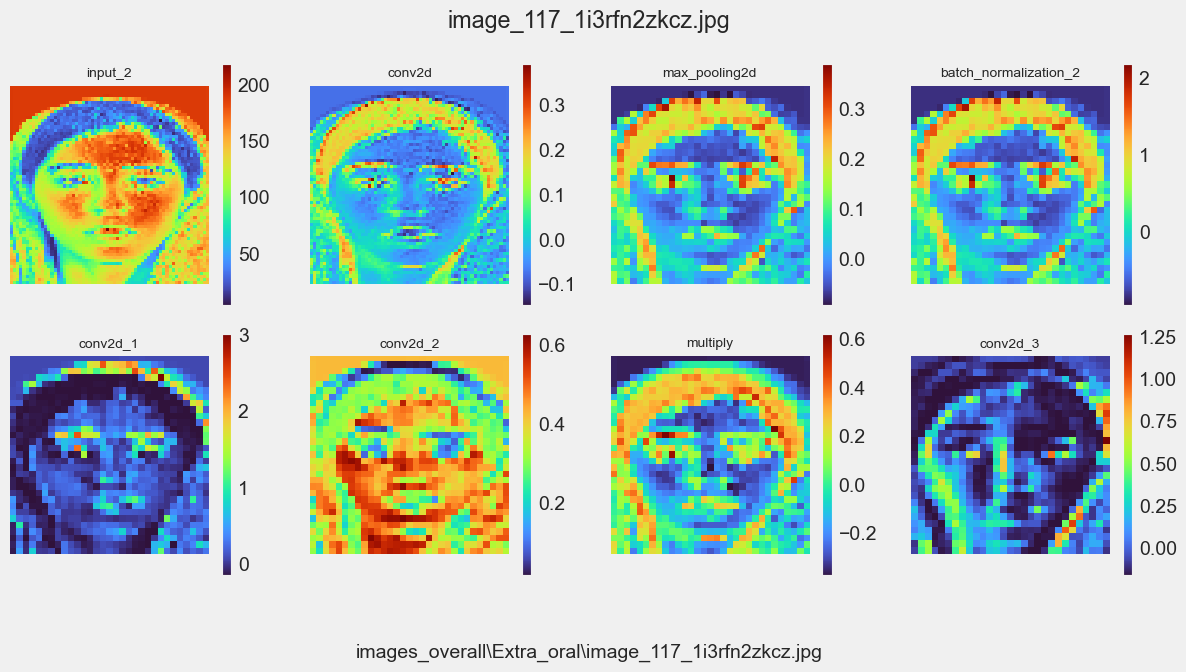

In [14]:
from tensorflow.keras import models
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import random
import os

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
layer_indices = [0, 2, 3, 4,5,6,7,8]
layer_outputs = []
for i in layer_indices:
    if i < len(model_incep.layers):
        layer_outputs.append(model_incep.layers[i].output)
    else:
        print(f"Invalid layer index: {i}")

activation_model = models.Model(inputs=model_incep.input, outputs=layer_outputs)

batch, _ = train_gen.next()
img_idx = random.choice(range(batch.shape[0]))
x = batch[img_idx]
img_path = train_gen.filepaths[img_idx]
activations = activation_model.predict(np.expand_dims(x, axis=0))

plt.suptitle(os.path.basename(img_path))
plt.tight_layout()

# Add image path to the figure
plt.text(0.5, -0.1, img_path, ha='center', transform=fig.transFigure)
plt.show()

# Test random Image

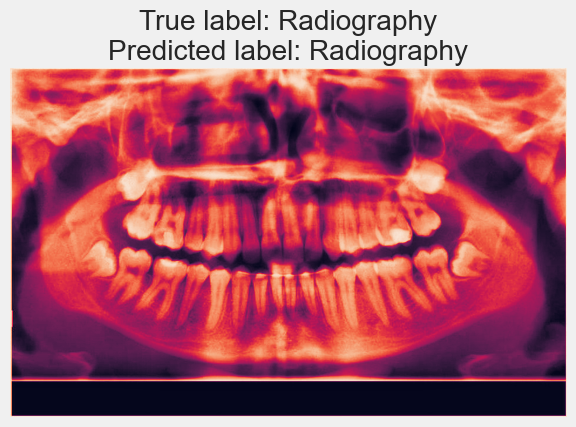

In [30]:
from PIL import Image
from tensorflow.keras.preprocessing import image
batch, _ = test_gen.next()
img_idx = np.random.choice(range(batch.shape[0]))
img_path = test_gen.filepaths[img_idx]
pil_img = Image.open(img_path)
img = image.load_img(img_path, target_size=(imsize, imsize))
img = image.img_to_array(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = np.expand_dims(img, axis=0)
classes_dir =  ['Extra_oral','Intra_oral','Radiography']
preds = model_incep.predict(img)
preds = np.argmax(preds)
pred_label = classes_dir[preds]
true_label = test_gen.labels[img_idx]
true_label = classes_dir[true_label]
plt.imshow(pil_img)
plt.title(f"True label: {true_label}\nPredicted label: {pred_label}")
plt.axis('off')
plt.show()

# Save